In [10]:
import pandas as pd
# pd.set_option("display.float_format", "{:.3f}".format)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import shap
import seaborn as sns
from IPython.display import display, Markdown, Latex
import random
random.seed(42)
import os
 
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.set_seed(seed)
    random.seed

In [11]:
data = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)

In [12]:
site_id = 3
data = data[(data['site'] == site_id) & (data['age'] <= 65) & (data['age'] >= 40)].copy()

In [13]:
X = data[['bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc']]
y1 = data.loc[:,'htn_jnc7_qc']

<Axes: ylabel='Density'>

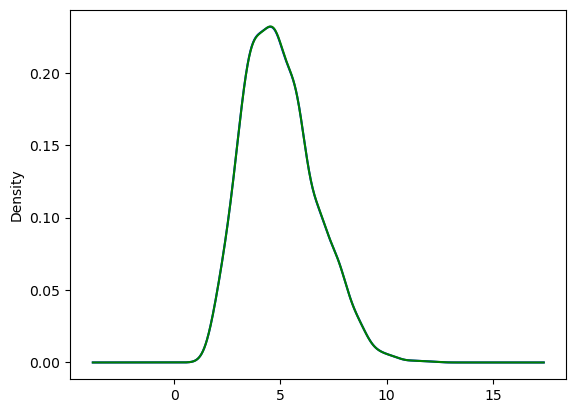

In [14]:
dff = data.mask(data == -999, np.nan).copy()

from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff[X.columns])
train_t = imputer.transform(dff[X.columns])
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=X.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff['visceral_fat_qc'].plot(kind='kde', ax=ax, color='blue')
treated['visceral_fat_qc'].plot(kind='kde', ax=ax, color='green')

In [15]:
y1 = dff[['htn_jnc7_qc']]

In [16]:
predictors = ['bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc']

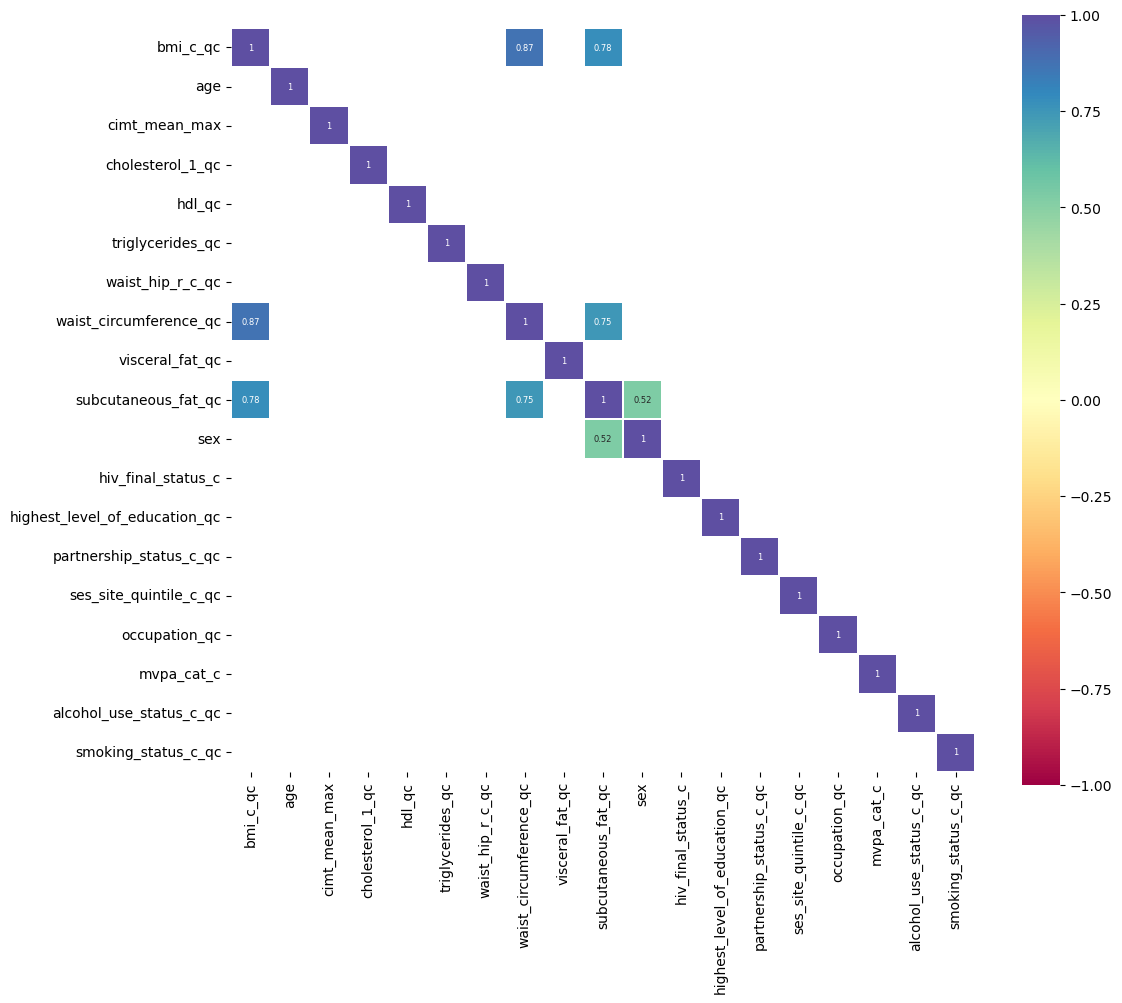

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify correlated variables using correlation coefficients
correlation_matrix = treated.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]


plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.5) | (correlation_matrix <= -0.4)], 
            cmap='Spectral', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 6}, square=True);

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42, stratify=treated[['sex']])

# Initialize XGBoost classifier
model = xgb.XGBClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
model.set_params(**best_params)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
predictions = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, predictions)
print(f"The AUC score for the optimized model is: {auc_score}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV]

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Load your dataset
# data = pd.read_csv('your_dataset.csv')
# X = data.drop('target_column', axis=1)
# y = data['target_column']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42, stratify=treated[['sex']])

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    # 'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    # 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize the XGBClassifier
xgb_clf = XGBClassifier(eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model using AUC
auc_score = roc_auc_score(y_test, predictions)
print(f"The AUC score for the optimized model is: {auc_score}")


Fitting 3 folds for each of 2000 candidates, totalling 6000 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.2s[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s

[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END learning_rate=

`use_label_encoder` is deprecated in 1.7.0.


The AUC score for the optimized model is: 0.7023468057366363
